# Rossmann_sales_forecast  

### 贺新宇

In [2]:
# 导入需要的库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn import cross_validation
from sklearn.grid_search import GridSearchCV
from __future__ import division
import operator

# 用pandas读取数据
data1 = pd.read_csv('./data/train.csv')
data2 = pd.read_csv('./data/store.csv')
data3 = pd.read_csv('./data/test.csv')

## 探索数据

In [3]:
data1.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [4]:
data2.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [5]:
data3.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [6]:
# 合并数据集
train_raw = pd.merge(data1, data2, how='left', on='Store')
test_raw = pd.merge(data3, data2, how='left', on='Store')

In [7]:
train_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [8]:
test_raw.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,1,4,2015-09-17,1.0,1,0,0,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,3,4,2015-09-17,1.0,1,0,0,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
2,3,7,4,2015-09-17,1.0,1,0,0,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN
3,4,8,4,2015-09-17,1.0,1,0,0,a,a,7520.0,10.0,2014.0,0,NaN,NaN,NaN
4,5,9,4,2015-09-17,1.0,1,0,0,a,c,2030.0,8.0,2000.0,0,NaN,NaN,NaN


In [9]:
train_raw.info()
print("--------------------------------")
test_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
Store                        1017209 non-null int64
DayOfWeek                    1017209 non-null int64
Date                         1017209 non-null object
Sales                        1017209 non-null int64
Customers                    1017209 non-null int64
Open                         1017209 non-null int64
Promo                        1017209 non-null int64
StateHoliday                 1017209 non-null object
SchoolHoliday                1017209 non-null int64
StoreType                    1017209 non-null object
Assortment                   1017209 non-null object
CompetitionDistance          1014567 non-null float64
CompetitionOpenSinceMonth    693861 non-null float64
CompetitionOpenSinceYear     693861 non-null float64
Promo2                       1017209 non-null int64
Promo2SinceWeek              509178 non-null float64
Promo2SinceYear              509178 non-null f

In [10]:
train_raw.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.014567e+06,693861.000000,693861.000000,1.017209e+06,509178.000000,509178.000000
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01,5.430086e+03,7.222866,2008.690228,5.005638e-01,23.269093,2011.752774
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01,7.715324e+03,3.211832,5.992644,4.999999e-01,14.095973,1.662870
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+01,1.000000,1900.000000,0.000000e+00,1.000000,2009.000000
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00,7.100000e+02,4.000000,2006.000000,0.000000e+00,13.000000,2011.000000
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00,2.330000e+03,8.000000,2010.000000,1.000000e+00,22.000000,2012.000000
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00,6.890000e+03,10.000000,2013.000000,1.000000e+00,37.000000,2013.000000
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00,7.586000e+04,12.000000,2015.000000,1.000000e+00,50.000000,2015.000000


宏观地对数据集进行探索、观察，发现一些问题：  
一是数据类型的问题：需要对一些列进行格式转换和独热编码。  
二是缺失值的问题：store数据集和test数据集均有缺失值的情况。    
三是训练集和测试集特征不一致的问题：测试集相比训练集少了一个Customers特征。  
四是特征选择的问题，需要筛选出对预测最有用的特征。

## 初级可视化和数据预处理  
依次对每个变量（列）进行探索性数据分析？

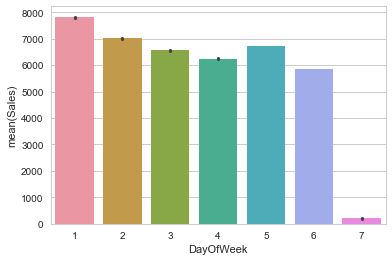

In [11]:
# 1、DayOfWeek
# 一周每天的平均销量
sns.set_style('whitegrid')
sns.barplot(x='DayOfWeek', y='Sales', data=train_raw)

In [12]:
# 2、Date
# 原数据中Date是字符串，首先转换为pandas的时间格式
train_raw['Date'] = pd.to_datetime(train_raw['Date'])
test_raw['Date'] = pd.to_datetime(test_raw['Date'])

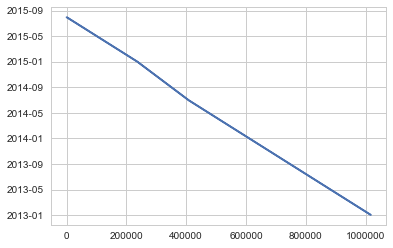

In [13]:
# 查看时间列的连续性
plt.plot(train_raw.index,train_raw['Date'])

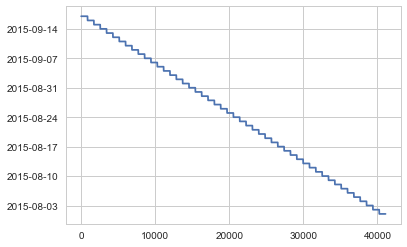

In [14]:
plt.plot(test_raw.index,test_raw['Date'])

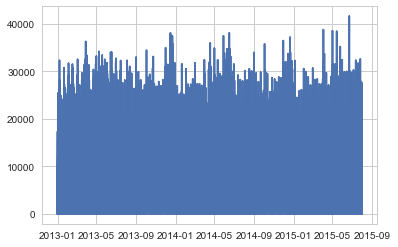

In [15]:
# 查看每天的销量趋势变化
plt.plot(train_raw['Date'],train_raw['Sales'])

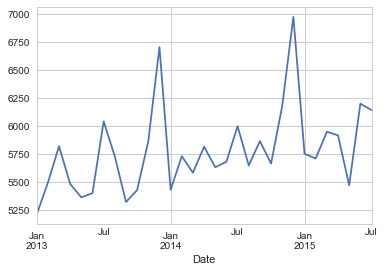

In [16]:
# 上图噪音较多不易观察，先转换为每月平均销量看趋势变化
# 按月平均销量看销量趋势
index = train_raw['Date']
temp = train_raw['Sales']
temp.index = index
temp = temp.to_period('M')
temp1 = temp.groupby(level=0).mean()
temp1.plot()

In [17]:
# 由上图可见销量随时间呈现一定规律性趋势。
# 提取Date列中的各独立特征并加入数据集
train_raw['Year'] = train_raw.Date.dt.year
train_raw['MonthofYear'] = train_raw.Date.dt.month
train_raw['WeekofYear'] = train_raw.Date.dt.weekofyear
train_raw['DayofMonth'] = train_raw.Date.dt.day
test_raw['Year'] = test_raw.Date.dt.year
test_raw['MonthofYear'] = test_raw.Date.dt.month
test_raw['WeekofYear'] = test_raw.Date.dt.weekofyear
test_raw['DayofMonth'] = test_raw.Date.dt.day

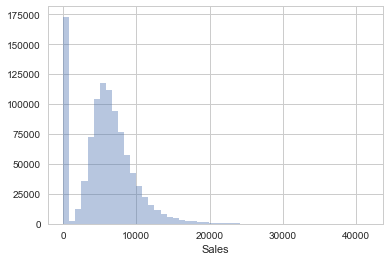

In [18]:
# 3、Sales
sns.distplot(train_raw['Sales'], kde=False)

In [19]:
# 进行log转换
train_raw['Sales'] = train_raw['Sales'].apply(lambda x:np.log(x+1))

In [20]:
# 4、Open
# 根据之前的数据信息，test数据集的Open列出现少量缺失值
# 查询缺失值
test_raw[test_raw['Open'].isnull().values==True]

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,...,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,MonthofYear,WeekofYear,DayofMonth
479,480,622,4,2015-09-17,NaN,1,0,0,a,c,...,NaN,NaN,0,NaN,NaN,NaN,2015,9,38,17
1335,1336,622,3,2015-09-16,NaN,1,0,0,a,c,...,NaN,NaN,0,NaN,NaN,NaN,2015,9,38,16
2191,2192,622,2,2015-09-15,NaN,1,0,0,a,c,...,NaN,NaN,0,NaN,NaN,NaN,2015,9,38,15
3047,3048,622,1,2015-09-14,NaN,1,0,0,a,c,...,NaN,NaN,0,NaN,NaN,NaN,2015,9,38,14
4759,4760,622,6,2015-09-12,NaN,0,0,0,a,c,...,NaN,NaN,0,NaN,NaN,NaN,2015,9,37,12
5615,5616,622,5,2015-09-11,NaN,0,0,0,a,c,...,NaN,NaN,0,NaN,NaN,NaN,2015,9,37,11
6471,6472,622,4,2015-09-10,NaN,0,0,0,a,c,...,NaN,NaN,0,NaN,NaN,NaN,2015,9,37,10
7327,7328,622,3,2015-09-09,NaN,0,0,0,a,c,...,NaN,NaN,0,NaN,NaN,NaN,2015,9,37,9
8183,8184,622,2,2015-09-08,NaN,0,0,0,a,c,...,NaN,NaN,0,NaN,NaN,NaN,2015,9,37,8
9039,9040,622,1,2015-09-07,NaN,0,0,0,a,c,...,NaN,NaN,0,NaN,NaN,NaN,2015,9,37,7


参考[这里](https://www.kaggle.com/c/rossmann-store-sales/discussion/16835)的讨论，将此处的缺失值填补为1.

In [21]:
# 填充缺失值
test_raw['Open'] = test_raw['Open'].fillna(1)

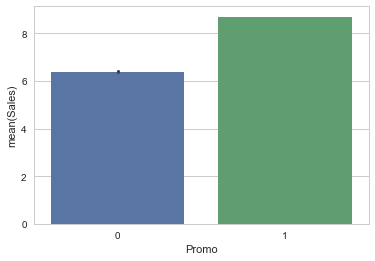

In [22]:
# 5、Promo
sns.barplot(x='Promo', y='Sales', data=train_raw)

In [23]:
# 6、StateHoliday
# 观察之前的数据集信息发现，StateHoliday列不是数值型变量
train_raw['StateHoliday'].value_counts(dropna=False)

0    855087
0    131072
a     20260
b      6690
c      4100
Name: StateHoliday, dtype: int64

In [24]:
# 而且取0时还有两种格式
train_raw['StateHoliday'].unique()

array(['0', 'a', 'b', 'c', 0L], dtype=object)

In [25]:
# 将StateHoliday的特征值格式进行统一
train_raw['StateHoliday'] = train_raw['StateHoliday'].replace(0L,'0')
test_raw['StateHoliday'] = test_raw['StateHoliday'].replace(0L,'0')
train_raw['StateHoliday'].unique()

array(['0', 'a', 'b', 'c'], dtype=object)

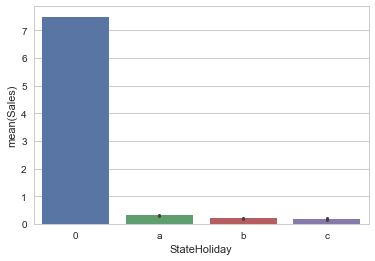

In [26]:
sns.barplot(x='StateHoliday', y='Sales', data=train_raw, order=['0','a','b','c'])

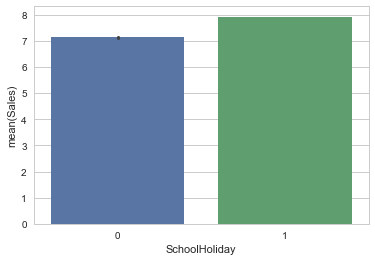

In [27]:
# 7、SchoolHoliday
sns.barplot(x='SchoolHoliday', y='Sales', data=train_raw)

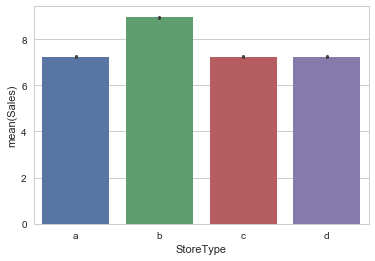

In [28]:
# 8、StoreType
sns.barplot(x='StoreType', y='Sales', data=train_raw, order=['a','b','c','d'])

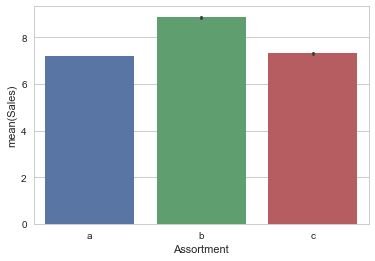

In [29]:
# 9、Assortment
sns.barplot(x='Assortment', y='Sales', data=train_raw, order=['a','b','c'])

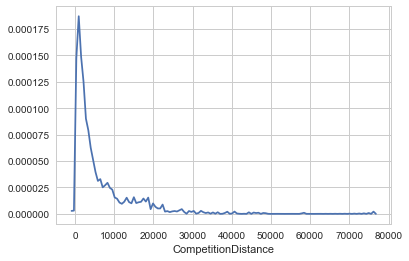

In [30]:
# 10、CompetitionDistance
# 观察分布
sns.distplot(train_raw['CompetitionDistance'], hist=False)

In [31]:
# 倾斜数据集进行log转换
train_raw['CompetitionDistance'] = train_raw['CompetitionDistance'].apply(lambda x:np.log(x+1))
test_raw['CompetitionDistance'] = test_raw['CompetitionDistance'].apply(lambda x:np.log(x+1))

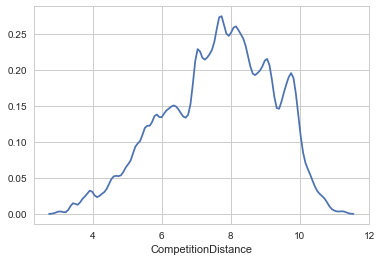

In [32]:
sns.distplot(train_raw['CompetitionDistance'], hist=False)

In [33]:
# 11、CompetitionOpenSinceMonth
train_raw['CompetitionOpenSinceMonth'].value_counts(dropna=False)

NaN      323348
 9.0     114254
 4.0      87076
 11.0     84455
 3.0      63548
 7.0      59434
 12.0     57896
 10.0     55622
 6.0      45444
 5.0      39608
 2.0      37886
 8.0      36186
 1.0      12452
Name: CompetitionOpenSinceMonth, dtype: int64

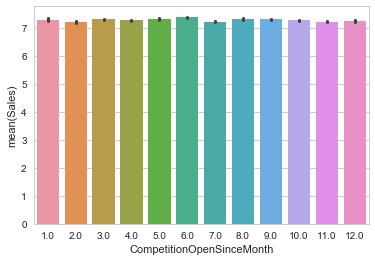

In [34]:
sns.barplot(x='CompetitionOpenSinceMonth', y='Sales', data=train_raw)

In [35]:
# 12、CompetitionOpenSinceYear
train_raw['CompetitionOpenSinceYear'].value_counts(dropna=False)

NaN        323348
 2013.0     75426
 2012.0     74299
 2014.0     63732
 2005.0     56564
 2010.0     51258
 2011.0     49396
 2009.0     49396
 2008.0     48476
 2007.0     43744
 2006.0     42802
 2015.0     35060
 2002.0     24882
 2004.0     19804
 2003.0     16794
 2001.0     14704
 2000.0      9236
 1999.0      7352
 1990.0      4710
 1994.0      1884
 1995.0      1700
 1998.0       942
 1961.0       942
 1900.0       758
Name: CompetitionOpenSinceYear, dtype: int64

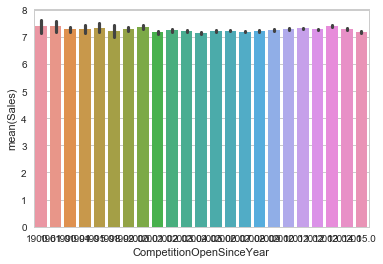

In [36]:
sns.barplot(x='CompetitionOpenSinceYear', y='Sales', data=train_raw)

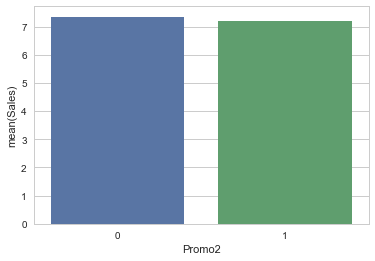

In [37]:
# 13、Promo2
sns.barplot(x='Promo2', y='Sales', data=train_raw)

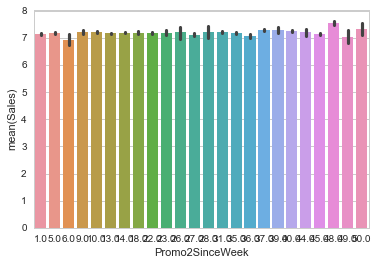

In [38]:
# 14、Promo2SinceWeek
sns.barplot(x='Promo2SinceWeek', y='Sales', data=train_raw)

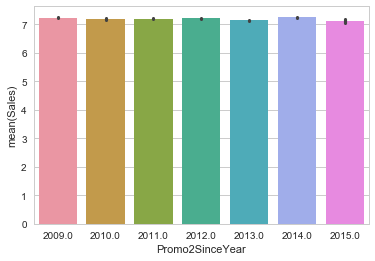

In [39]:
# 15、Promo2SinceYear
sns.barplot(x='Promo2SinceYear', y='Sales', data=train_raw)

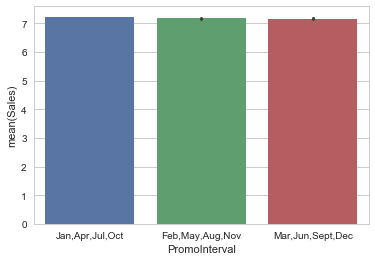

In [40]:
# 16、PromoInterval
sns.barplot(x='PromoInterval', y='Sales', data=train_raw)

In [41]:
train_raw.corr()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,Year,MonthofYear,WeekofYear,DayofMonth
Store,1.000000,-0.000008,0.000067,0.024325,-0.000047,0.000058,0.000641,-0.052372,-0.050746,-0.004592,0.008488,0.009865,0.038928,0.000290,0.001467,0.001421,0.000023
DayOfWeek,-0.000008,1.000000,-0.543216,-0.386445,-0.528963,-0.392925,-0.205388,0.000005,0.000006,-0.000025,0.000168,0.000174,0.000049,0.001937,-0.005362,-0.004880,0.005136
Sales,0.000067,-0.543216,1.000000,0.682308,0.992949,0.337111,0.090409,-0.005584,-0.002831,0.004975,-0.020747,0.008087,-0.002156,0.003982,0.006712,0.012371,0.026956
Customers,0.024325,-0.386445,0.682308,1.000000,0.616768,0.316169,0.071568,-0.203230,-0.030954,0.008931,-0.150159,0.040531,0.028974,-0.001212,0.038179,0.041404,-0.004473
Open,-0.000047,-0.528963,0.992949,0.616768,1.000000,0.295042,0.086171,0.001067,0.001384,0.002771,-0.008309,-0.002430,0.001637,-0.001009,-0.000681,0.004792,0.033428
Promo,0.000058,-0.392925,0.337111,0.316169,0.295042,1.000000,0.067483,-0.000045,-0.000023,0.000152,-0.000983,-0.001008,-0.000283,0.024300,-0.011747,0.000572,-0.108325
SchoolHoliday,0.000641,-0.205388,0.090409,0.071568,0.086171,0.067483,1.000000,-0.003331,-0.000526,0.001520,-0.006909,-0.003133,-0.003682,-0.036535,0.103282,0.071052,0.030538
CompetitionDistance,-0.052372,0.000005,-0.005584,-0.203230,0.001067,-0.000045,-0.003331,1.000000,-0.033032,0.009431,-0.091907,-0.020439,-0.085927,-0.000222,-0.001116,-0.001081,-0.000020
CompetitionOpenSinceMonth,-0.050746,0.000006,-0.002831,-0.030954,0.001384,-0.000023,-0.000526,-0.033032,1.000000,-0.060594,-0.009383,-0.036251,0.050326,-0.000121,-0.000624,-0.000604,-0.000006
CompetitionOpenSinceYear,-0.004592,-0.000025,0.004975,0.008931,0.002771,0.000152,0.001520,0.009431,-0.060594,1.000000,-0.077336,-0.079784,0.012155,0.000771,0.003916,0.003791,0.000056


## 特征预处理
结合之前的探索性分析以及特征的相关性，以及后面建模后特征重要性的获取，对各特征作以下处理：  
DayOfWeek显著影响销量，保留。Customers测试集中没有，删掉。Date替换为Year，MonthofYear，WeekofYear，DayofMonth。对于Open，经处理之后删掉（原因见下面）。StateHoliday、StoreType、Assortment可以直接替换为数值而不进行独热编码。CompetitionDistance的对数变换（标准化）已经在前面完成。将CompetitionOpenSinceMonth和CompetitionOpenSinceYear结合形成新的变量CompetitionOpenMonth，Promo2SinceWeek和Promo2SinceYea结合形成新变量Promo2sinceMonth。StateHoliday、SchoolHoliday、StoreType、Assortment、Promo2暂时保留（后面依据特征重要性排序进行删减）。

新增特征的处理操作参考[这里](https://www.kaggle.com/cast42/xgboost-in-python-with-rmspe-v2/code)

In [42]:
# 新增特征
train_raw['CompetitionOpenMonth'] = 12 * (train_raw.Year - train_raw.CompetitionOpenSinceYear) + (train_raw.MonthofYear - train_raw.CompetitionOpenSinceMonth)
train_raw['Promo2sinceMonth'] = 12 * (train_raw.Year - train_raw.Promo2SinceYear) + (train_raw.WeekofYear - train_raw.Promo2SinceWeek) / 4.0
test_raw['CompetitionOpenMonth'] = 12 * (test_raw.Year - test_raw.CompetitionOpenSinceYear) + (test_raw.MonthofYear - test_raw.CompetitionOpenSinceMonth)
test_raw['Promo2sinceMonth'] = 12 * (test_raw.Year - test_raw.Promo2SinceYear) + (test_raw.WeekofYear - test_raw.Promo2SinceWeek) / 4.0

缺失值分析：分析各变量缺失值产生的原因。  
Open的缺失值前面已处理；
Promo2SinceWeek和Promo2SinceYear的缺失值，观察可知与变量Promo2对应，Promo2取0时即为缺失值，因此可以将其缺失值填充为0。
CompetitionOpenSinceMonth和CompetitionOpenSinceYear的缺失值，则是另一种情况，CompetitionDistance取值不为0时仍然缺失，说明是确实无数据，所以暂时不进行填充。

In [43]:
# 对Promo2sinceMonth缺失值进行填充
train_raw['Promo2sinceMonth'] = train_raw['Promo2sinceMonth'].fillna(0)
test_raw['Promo2sinceMonth'] = test_raw['Promo2sinceMonth'].fillna(0)

In [ ]:
# 特征缩放、归一化、标准化
# 前面已处理

In [ ]:
# 异常值处理
# 暂不处理

In [44]:
# 独热编码
# 考虑数据规模较大，不采用生成dummies变量的方式
train_raw['StateHoliday'].replace(['0','a','b','c'],[0,1,2,3],inplace=True)
test_raw['StateHoliday'].replace(['0','a','b','c'],[0,1,2,3],inplace=True)
train_raw['StoreType'].replace(['a','b','c','d'],[0,1,2,3],inplace=True)
test_raw['StoreType'].replace(['a','b','c','d'],[0,1,2,3],inplace=True)
train_raw['Assortment'].replace(['a','b','c'],[0,1,2],inplace=True)
test_raw['Assortment'].replace(['a','b','c'],[0,1,2],inplace=True)

In [ ]:
# 特征工程：如特征转换
# 暂不使用

In [45]:
# 将训练集中关门的删掉。
train = train_raw[train_raw['Open']==1]
# 将测试集中关门的id提取出来，保存。(最后提交结果时，这部分id对应的销量预测为0)
closed_ids = test_raw['Id'][test_raw['Open']==0].values
# 将测试集中开门的id提取出来，保存。(最后提交结果时，这部分id对应的销量预测为模型的预测值)
opened_ids = {}
for i in range(1,1116):
    opened_ids[i] = test_raw['Id'][test_raw['Open']==1][test_raw['Store']==i].values
# 将训练集中关门的删掉。
test = test_raw[test_raw['Open']==1]

In [46]:
# 切分数据集、提取特征和标签
def subset(data, number):
    child = data.loc[train['Store']==number]
    train_labels = child['Sales']
    train_features = child.drop(child.columns[[0,2,3,4,5,7,8,9,10,11,12,13,14,15,16,17,23]], axis=1) 
    return train_features, train_labels       

## 模型构建与优化
参考纳米学位中寻找捐献者项目。

In [47]:
# 设定评估指标
def metric_RMSPE(y_true, y_predict):
    y1 = np.array(y_predict)
    y2 = np.array(y_true)
    n = len(y_true)
    temp = np.square((y1 - y2)/y2).sum()
    score = np.sqrt(temp/n)
    return score

In [48]:
# 构建模型
# XGBoost
def model_xgb(x_train, y_train):
    reg = XGBRegressor(learning_rate=0.1, min_child_weight=1, n_estimators=50, max_depth=3, objective='reg:linear', seed=10)      
    # 获得参数
    params = reg.get_xgb_params()
    # 对输入进行格式转换
    dtrain = xgb.DMatrix(x_train, y_train)
    # xgb的交叉验证
    cvresult = xgb.cv(params, dtrain, num_boost_round=reg.get_params()['n_estimators'], nfold=5)
    reg.set_params(n_estimators=cvresult.shape[0])
    # 网格调参
    params_set = {'learning_rate':(0.1,0.3),'min_child_weight':(1,2,3),'max_depth':(4,5,6)}
    grid = GridSearchCV(reg, params_set, cv=5)
    # 输入数据，进行训练
    grid.fit(x_train, y_train)
    # 获得最优模型
    best_reg = grid.best_estimator_     
    return best_reg

在样本集上进行调参

In [49]:
# 以Store1作为样本
features_sample,labels_sample = subset(train,1)
# 在样本上切分验证集
from sklearn.model_selection import train_test_split
X_train_s,X_val_s,y_train_s,y_val_s = train_test_split(features_sample,labels_sample,test_size=0.2,random_state=0)
# 用模型预测结果
pred_s = model_xgb(X_train_s, y_train_s).predict(X_val_s)
# 评估误差
metric_RMSPE(np.expm1(y_val_s), np.expm1(pred_s))

0.10325734882553594

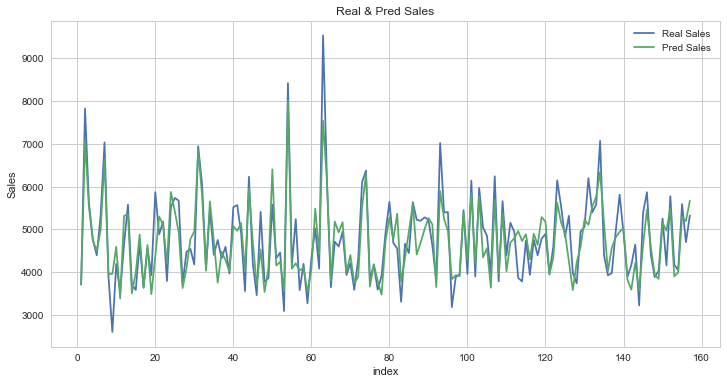

In [70]:
# 结果可视化（在样本上）
plt.figure(figsize=(12,6))
x = range(1,158)
plt.plot(x, np.expm1(y_val_s), label='Real Sales')
plt.plot(x, np.expm1(pred_s), label='Pred Sales')
plt.title('Real & Pred Sales')
plt.xlabel('index')
plt.ylabel('Sales')
plt.legend()

In [78]:
# 特征重要性查看
importances = model_xgb(X_train_s, y_train_s).booster().get_fscore()
importances

{'CompetitionOpenMonth': 85,
 'DayOfWeek': 90,
 'DayofMonth': 171,
 'MonthofYear': 52,
 'Promo': 31,
 'WeekofYear': 102,
 'Year': 13}

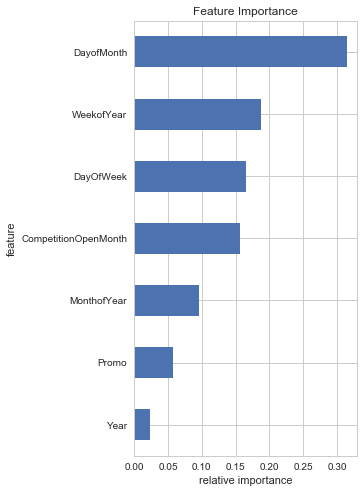

In [79]:
# 特征重要性的可视化
importances_v = sorted(importances.items(), key=operator.itemgetter(1))
df = pd.DataFrame(importances_v, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()
featp = df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(4, 8))
plt.title('Feature Importance')
plt.xlabel('relative importance')

特征重要性可视化部分参考[这里](https://www.kaggle.com/cast42/xgboost-in-python-with-rmspe-v2/code)

## 在测试集上进行预测

In [37]:
submission = pd.DataFrame()
submission['Id'] = data3['Id']
sales = pd.Series()
for i in range(1,1116):
    X_train_i,y_train_i = subset(train, i)
    test_i = test.loc[test['Store']==i]
    X_test_i = test_i.drop(test_i.columns[[0,1,3,4,6,7,8,9,10,11,12,13,14,15,16,22]],axis=1)
    pred_i = model_xgb(X_train_i, y_train_i).predict( X_test_i)
    sales = sales.append(pd.Series(np.expm1(pred_i), index=opened_ids[i]-1))
sales = sales.append(pd.Series(0, index=closed_ids-1))
submission['Sales'] = sales
# 导出csv文件
submission.to_csv('./data/submission.csv', index=False)